<a href="https://colab.research.google.com/github/samurai-kai/ME570/blob/main/Kai_571_BC_DataProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports


In [1]:
import json
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import wandb
import cv2
import tensorflow as tf
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d
import shutil

In [2]:
# Connect to Google Drive
import os
from google.colab import drive

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

# Update 'base_dir' with the path to your private workspace on Google Drive
base_dir = '/content/drive/MyDrive/00_Workspace'

if not os.path.exists(base_dir):
  raise FileNotFoundError(f'Base directory {base_dir} does not exist')

# Directory to store the processed speedbump datasets
dataset_dir = base_dir + '/datasets/acc'

Mounted at /content/drive


In [3]:
datasets = os.listdir(dataset_dir)

print("Your datasets:")
for name in datasets:
    print(f" - {name}")

Your datasets:
 - pilot_acc_testset.npz
 - car_best.onnx
 - car_best.pt
 - pilot_acc_left_gt.npz
 - pilot_acc_right_gt.npz


## Utils

In [4]:
# Weighting the straights 5× higher did not lead to good results in practice,
# possibly because the model still saw too many curves during training.

# Simply reducing the number of curves (i.e. using a balanced dataset)
# worked better by forcing the model to learn from both classes equally.

# Define weighted sparse categorical crossentropy
def weighted_sparse_categorical_crossentropy(class_weights):
    class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        weights = tf.gather(class_weights, y_true)

        ce = tf.keras.backend.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
        return tf.multiply(ce, weights)  # Element-wise multiply

    return loss_fn

In [5]:
def median_filter(data, kernel_size=5):
    return medfilt(data, kernel_size=kernel_size)

def preprocess_images(im_selected, ymin=120, ymax=265):
    """
    Preprocess a list of RGB images for input into a TensorFlow model.

    Steps:
    - Crop the vertical range of each image from ymin to ymax (e.g., remove sky and hood).
    - Convert the cropped image to grayscale.
    - Normalize pixel values to the range [0, 1].
    - Add a channel dimension to match TensorFlow's expected input shape.

    Args:
        im_selected (List[np.ndarray]): List of RGB images as NumPy arrays (H, W, 3).
        ymin (int): Starting row index for cropping.
        ymax (int): Ending row index for cropping.

    Returns:
        np.ndarray: Array of shape (N, ymax - ymin, W, 1) with float32 grayscale images.
    """
    processed = []
    for img in im_selected:
        # Crop image vertically to remove irrelevant areas (e.g., sky, car hood)
        img_cropped = img[ymin:ymax]

        # Convert the cropped image to grayscale (1 channel)
        gray = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2GRAY)

        # Normalize pixel values to the range [0, 1]
        norm = gray.astype(np.float32) / 255.0

        # Add channel dimension to match model input shape (H, W, 1)
        processed.append(np.expand_dims(norm, axis=-1))

    # Return a NumPy array of shape (N, H, W, 1)
    return np.array(processed, dtype=np.float32)


def filter_min_distance(idx, min_distance=10):
    # Given a list of indices, return a subset where each index is at least
    # `min_distance` apart from the previous one.
    #
    # Example:
    #   idx = [1, 2, 3, 4, 5, 15]
    #   filter_min_distance(idx, min_distance=10) -> [1, 15]
    #
    # Explanation:
    #   - Start with 1
    #   - Skip 2–5 because they're too close to 1
    #   - 15 is far enough from 1 (15 - 1 = 14 >= 10), so it's added

    # Convert input to sorted NumPy array
    idx = np.sort(np.array(idx))
    selected = []

    for i in idx:
        # Add the index if this is the first one,
        # or if it's at least `min_distance` away from the last selected
        if not selected or i - selected[-1] >= min_distance:
            selected.append(i)

    # Return the filtered indices as a NumPy array
    return np.array(selected)


def sample_balanced_with_flipping(y, images, bins=9, min_distance=10):
    """
    Augments data by flipping, balances bins, and filters for minimum spacing.

    Parameters:
    - y: 1D numpy array of steering angles
    - images: numpy array of shape (N, H, W, C)
    - bins: number of histogram bins
    - min_distance: minimum index spacing in each bin

    Returns:
    - y_selected: filtered and balanced steering angles
    - im_selected: corresponding selected images
    """
    y = np.array(y)
    images = np.array(images)

    # Flip images and angles
    images_flipped = np.flip(images, axis=2)
    y_flipped = -y

    # Concatenate originals and flipped
    y_combined = np.concatenate([-y, y])
    images_combined = np.concatenate([images_flipped, images], axis=0)

    # Bin edges
    _, edges = np.histogram(y_combined, bins=bins)

    # Filtered bin-wise indices
    filtered_bins = []
    for i in range(len(edges) - 1):
        idx = np.where((y_combined >= edges[i]) & (y_combined < edges[i+1]))[0]
        filtered = filter_min_distance(idx, min_distance)
        filtered_bins.append(filtered)

    # Global N: minimum filtered size per bin
    N = min(len(b) for b in filtered_bins if len(b) > 0)

    # Select up to N indices per bin
    selected_indices = []
    for idx in filtered_bins:
        if len(idx) == 0:
            continue
        sel = np.linspace(0, len(idx) - 1, min(N, len(idx)), dtype=int)
        selected_indices.extend(idx[sel])

    selected_indices = np.array(selected_indices)

    # Final selection
    y_selected = y_combined[selected_indices]
    im_selected = images_combined[selected_indices]

    return y_selected, im_selected, selected_indices


In [6]:
def build_datasets(sets, val_split=0.2, batch_size=8):
    train_datasets = []
    val_datasets = []

    for x, y_angle, y_speed in sets:
        # Shuffle
        indices = np.random.permutation(len(x))
        x = x[indices]
        y_angle = y_angle[indices].astype(np.float32)
        y_speed = y_speed[indices].astype(np.int32)

        # Split into train/val
        val_size = int(val_split * len(x))
        x_val, x_train = x[:val_size], x[val_size:]
        y_val_steer, y_train_steer = y_angle[:val_size], y_angle[val_size:]
        y_val_speed, y_train_speed = y_speed[:val_size], y_speed[val_size:]

        # Build datasets
        train_ds = tf.data.Dataset.from_tensor_slices(
            (x_train, {'steering_angle': y_train_steer, 'speed': y_train_speed})
        ).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(
            (x_val, {'steering_angle': y_val_steer, 'speed': y_val_speed})
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        train_datasets.append(train_ds)
        val_datasets.append(val_ds)

    return train_datasets, val_datasets


In [7]:
def get_bounding_boxes(predictions, objects_3d):

    # Check if there are any predictions
    if len(predictions) == 0:
        return False, None

    p = predictions[0].cpu()  # Get the first prediction (move to CPU)
    all_boxes = p.boxes  # Access the bounding boxes
    ids = all_boxes.cls.numpy()  # Class IDs for each detected object
    confidences = all_boxes.conf.numpy()  # Confidence scores for each detection

    detections = {}
    for id, lbl in objects_3d.items():
      # Check if the class ID is present in the predictions
      if id in ids:

        # Filter the boxes with the target ID
        boxes = all_boxes[ids == id]
        conf = confidences[ids == id]

        # Take the bbox with the highest confidence
        corners = boxes.xyxy[np.argmax(conf)].numpy()

        # Extract the center and size (xyxy) of the box with the highest confidence
        detections[id] = {'name': lbl, 'corners': corners}

    if len(detections) == 0:
      return False, None
    else:
      return True, detections

def get_onnx_boxes(predictions, objects_3d):

    # Check if there are any predictions
    if len(predictions) == 0:
        return False, None

    p = predictions[0]  # Get the first prediction

    all_boxes = np.array(p.boxes)  # Access the bounding boxes
    ids = np.array(p.class_ids) # Class IDs for each detected object
    confidences = np.array(p.scores)  # Confidence scores for each detection

    detections = {}
    for id, lbl in objects_3d.items():
      # Check if the class ID is present in the predictions
      if id in ids:

        # Filter the boxes with the target ID
        boxes = all_boxes[ids == id]
        conf = confidences[ids == id]

        # Extract the center and size (xyxy) of the first box
        corners = boxes[np.argmax(conf)]

        # Extract the center and size (xyxy) of the box with the highest confidence
        detections[id] = {'name': lbl, 'corners': corners}

    if len(detections) == 0:
      return False, None
    else:
      return True, detections

In [8]:
# Lidar frame:   x-forward, y-left, z-down   (left-handed)
# Camera frame:  x-right,  y-down,  z-forward (right-handed OpenCV/ROS optical frame)

# Base rotation to align LiDAR frame with camera frame (without additional rotation)
R_base = np.array([
    [0,  -1,  0],
    [0,   0, -1],
    [1,   0,  0]
])

# Additional LiDAR rotation: 225 degrees (clockwise) around Z-axis
theta = np.deg2rad(228)
R_rot = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
])

# Final rotation: apply additional -45° Z-rotation on top of base rotation
R = R_base @ R_rot

# Translation from LiDAR to Camera in meters (x, y, z) in camera coordinates.
# Note: In the camera frame, +Y points down in the image — so adjusting the Y value moves the point cloud up or down in the image.
t = np.array([[-0.0015, -0.06, -0.04]])

# Combine into 3x4 transformation matrix
T = np.hstack((R, t.T))

K = np.array([
    [455.21691895,   0.0,         324.14334106],
    [  0.0,         455.26907349, 188.91212463],
    [  0.0,           0.0,           1.0      ]
])

In [9]:
class LidarToImageProjector:

  def __init__(self, K, T, im_w = 640, im_h = 360):
      self.K = K
      self.T = T
      self.im_w = im_w
      self.im_h = im_h

  def project_points_to_image(self, pts):
    # Add homogeneous coordinate
    pts_homo = np.hstack((pts, np.ones((pts.shape[0], 1))))

    # Transform from Lidar to Camera frame
    pts_transformed = (self.T @ pts_homo.T).T

    # Remove Lidar points that are behind the camera
    # Otherwise they would be incorrectly projected onto the image
    pts_transformed = pts_transformed[pts_transformed[:,2] > 1e-6]

    # Depth values (z)
    z = pts_transformed[:, 2]

    # Project to image plane
    pts_2d = self.K @ pts_transformed[:, :3].T

    # Perspectiv devision: f * x / z, f * y / z
    pixels = (pts_2d[:2] / pts_2d[2]).T

    # Remove pixels outside image boundaries
    x, y = pixels.T
    mask = (x >= 0) & (x < self.im_w) & (y >= 0) & (y < self.im_h)
    pixels = pixels[mask]
    z = z[mask]

    return pixels, z

## Load data

In [10]:
# Connect to Foxglove
!pip install -qq git+https://github.com/william-mx/foxglove-bag-reader.git
from foxglove_bag_reader import BagfileReader

API_KEY = "fox_sk_j4qRQHhh0cd8mgMAQzDXNPwhGEfkLOXe"
r = BagfileReader(API_KEY)
r.print_recordings()

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.3 MB/s eta 0:00:00
Available Recordings:

bshaped_track_all                        → 2y57fL95RUnUG5MW
bshaped_track_depth                      → rec_0dY0zYREG8TYFbTY
bshaped_track_following_left             → rec_0dX26NC9WkjKqTyi
bshaped_track_following_right            → rec_0dX27U8jsoFpbA2u
bshaped_track_odometry                   → rec_0dY0ylXuthVmxy44
circle_drive_fixed_speed_left            → rec_0dWf0XUVbrIrRtgL
cones_lidar_slam                         → rec_0dY0z7WHao9tYAZY
hallway_lidar_slam                       → rec_0dY106wizvoNRenI
imu_speed_stairs                         → rec_0dWf0csWqOJcTgWT
imu_static                               → rec_0dWf1wPygPWHB8ne
ir_lidar_calibration                     → rec_0dY10RmyGbqo3RYh
lid

In [11]:
%pip install -qq ultralytics==8.3.119 roboflow
import ultralytics
from roboflow import Roboflow
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.7/107.7 GB disk)


In [48]:
# Load the trained YOLO model from the specified path
model_path = '/content/drive/MyDrive/00_Workspace/models/william_best.pt'
model = YOLO(model_path)

id2label = model.names
label2id = {lbl: id for id, lbl in id2label.items()}
car_id = label2id['car']
print(model.names)

{0: 'car', 1: 'center', 2: 'green', 3: 'red', 4: 'speed_2mph', 5: 'speed_3mph', 6: 'stop', 7: 'yellow'}


In [44]:
# Projector for transforming LiDAR points into camera image
projector = LidarToImageProjector(K, T)

# Desired object(s), confidence threshold, distance cutoff
target_classes = ['car']
confidence_thresh = 0.682
dist_thresh = 1.8  # Distance threshold in meters

# Map object names to class IDs
id2label = model.names
objects_3d = {id: lbl for id, lbl in id2label.items() if lbl in target_classes}

for side in ['left', 'right']:
    name = f'bc_acc_{side}_lidar'

    y_visible = []
    distances = []
    detection_indices = []
    detected_distances = []

    # Open bagfile
    r.get_recording_by_name(name)

    # Load topics
    df_scan = r.parse_topic('/scan')
    df_ackermann = r.parse_topic('/rc/ackermann_cmd')
    df_camera = r.parse_topic('/camera/camera/color/image_raw')

    # Synchronize all dataframes by timestamp
    df_synced = r.sync_dataframes(df_camera, ack=df_ackermann, scan=df_scan)

    # Extract data
    y_angles = df_synced['steering_angle_ack'].values
    images = r.get_all_images('/camera/camera/color/image_raw')
    pointclouds = [np.array(pts) for pts in df_synced['pointcloud_scan'].values]

    for i, (pts, image) in enumerate(zip(pointclouds, images)):
        predictions = model(image, verbose=False)[0].cpu()
        all_bboxes = predictions.boxes

        # Get classes and confidence scores
        cls_ids = all_bboxes.cls.numpy()
        confidences = all_bboxes.conf.numpy()

        # Filter by confidence
        keep_idx = np.where(confidences > confidence_thresh)[0]
        filtered_ids = cls_ids[keep_idx]
        filtered_boxes = all_bboxes[keep_idx]

        # Find the best-matching car box (highest confidence)
        car_indices = [j for j, cls_id in enumerate(filtered_ids) if cls_id in objects_3d]

        if car_indices:
            # Get the index of the car with highest confidence
            best_idx = max(car_indices, key=lambda j: confidences[keep_idx[j]])

            label = objects_3d[filtered_ids[best_idx]]
            corners = filtered_boxes[best_idx].xyxy[0].tolist()  # [x1, y1, x2, y2]

            # Use this highest-confidence car box
            x1, y1, x2, y2 = corners
            xmin, xmax = sorted([x1, x2])
            ymin, ymax = sorted([y1, y2])

            # Project 3D points to 2D
            pixels, depth = projector.project_points_to_image(pts)
            x, y = pixels.T
            mask = (x >= xmin) & (x <= xmax) & (y >= ymin) & (y <= ymax)

            z_values = depth[mask]
            z_values = z_values[np.isfinite(z_values) & (z_values > 0)]

            if len(z_values) > 0:
                car_distance = np.median(z_values).item()
                if car_distance <= dist_thresh:
                    y_visible.append(1)
                    detection_indices.append(i)
                    detected_distances.append(car_distance)
                else:
                    y_visible.append(0)
                    detection_indices.append(i)
                    detected_distances.append(None)
            else:
                y_visible.append(0)
                detection_indices.append(i)
                detected_distances.append(None)
        else:
            y_visible.append(0)
            detection_indices.append(i)
            detected_distances.append(None)

    # Fill in distances list
    distances = [None] * len(images)
    for idx, dist in zip(detection_indices, detected_distances):
        distances[idx] = dist

    valid_indices = [i for i, d in enumerate(distances) if d is not None and not np.isnan(d)]
    valid_values = [distances[i] for i in valid_indices]

    if valid_indices:
        all_indices = np.arange(len(distances))
        distances = np.interp(all_indices, valid_indices, valid_values)

        # Forward fill any remaining NaNs
        for i in range(1, len(distances)):
            if np.isnan(distances[i]):
                distances[i] = distances[i - 1]
    else:
        distances = [np.nan] * len(images)

    # Convert to arrays
    y_visible = np.array(y_visible, dtype=np.uint8)
    y_distance = np.array(distances, dtype=np.float32)
    y_angles = np.array(y_angles, dtype=np.float32)

    # Summary print
    print(f"Loaded from {name}:")
    print(f" - Confidence thresh: {confidence_thresh}")
    print(f" - Distance thresh: {dist_thresh}")
    print(f" - Total images: {len(images)}")
    print(f" - Total steering angles: {len(y_angles)}")
    print(f" - Total visible (within {dist_thresh} m): {np.sum(y_visible)}")
    print(f" - Min distance: {np.nanmin(y_distance):.2f}, Max distance: {np.nanmax(y_distance):.2f}")

    # Save
    filepath = dataset_dir + f'/pilot_acc_{side}_gt.npz'
    np.savez_compressed(
        filepath,
        y_visible=y_visible,
        y_distance=y_distance,
        y_angles=y_angles
    )

Loaded from bc_acc_left_lidar:
 - Confidence thresh: 0.682
 - Distance thresh: 1.8
 - Total images: 1122
 - Total steering angles: 1122
 - Total visible (within 1.8 m): 389
 - Min distance: 0.53, Max distance: 1.79
Loaded from bc_acc_right_lidar:
 - Confidence thresh: 0.682
 - Distance thresh: 1.8
 - Total images: 799
 - Total steering angles: 799
 - Total visible (within 1.8 m): 331
 - Min distance: 0.64, Max distance: 1.77


## Analyze Data

Pulls loaded data

In [45]:
# Load left-side data
filepath_left = dataset_dir + '/pilot_acc_left_gt.npz'
data_left = np.load(filepath_left, allow_pickle=True)
steering_left = data_left['y_angles']
pts_left = data_left['y_distance']
visible_left = data_left['y_visible']


# Load right-side data
filepath_right = dataset_dir + '/pilot_acc_right_gt.npz'
data_right = np.load(filepath_right, allow_pickle=True)
steering_right = data_right['y_angles']
pts_right = data_right['y_distance']
visible_right = data_right['y_visible']

Plots distance data of car from YOLO/Lidar fusion

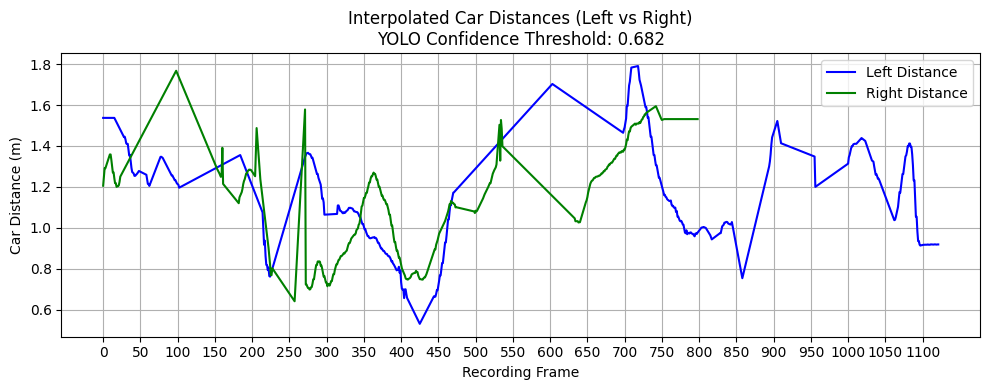

In [46]:
plt.figure(figsize=(10, 4))
plt.plot(pts_left, label='Left Distance', color='blue')
plt.plot(pts_right, label='Right Distance', color='green')
plt.xlabel("Recording Frame")
plt.ylabel("Car Distance (m)")
plt.title(f"Interpolated Car Distances (Left vs Right)\nYOLO Confidence Threshold: {confidence_thresh}")
plt.legend()
plt.grid(True)

# Set x-axis ticks every 50 frames
max_frames = max(len(pts_left), len(pts_right))
ticks = np.arange(0, max_frames, 50)
plt.xticks(ticks)

plt.tight_layout()
plt.show()

The test code below is set to review specific frames of interest selected from the distance plot above.

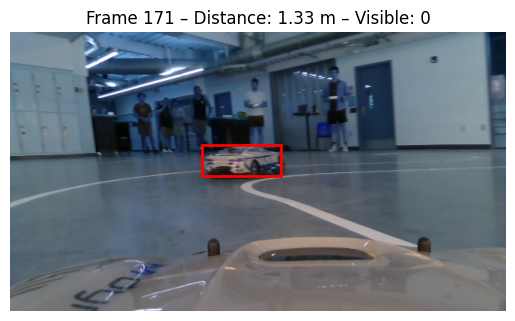

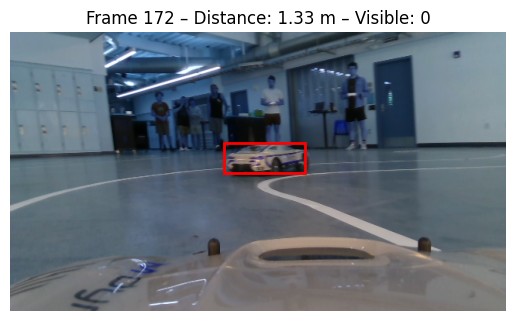

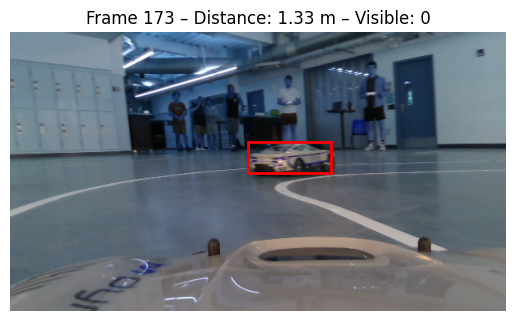

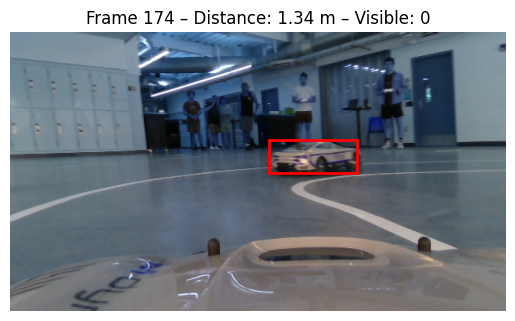

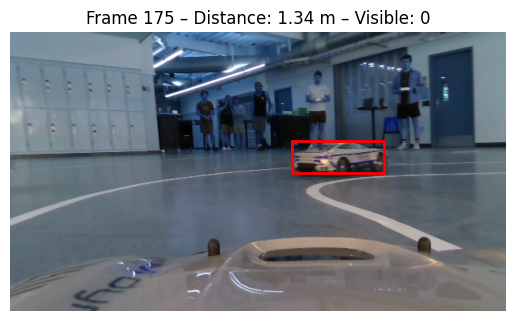

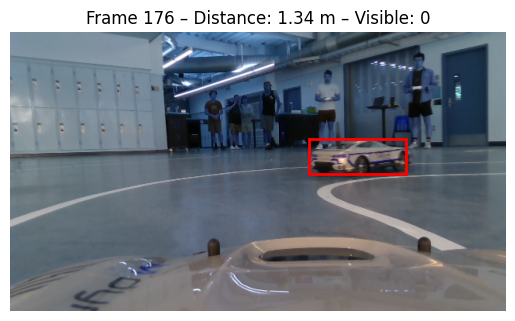

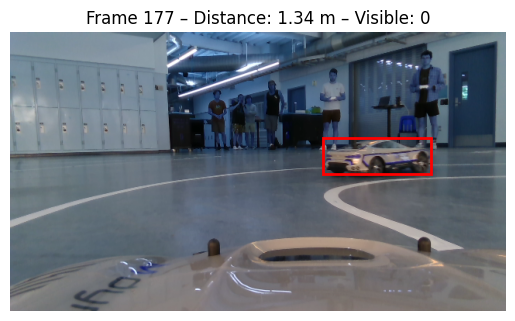

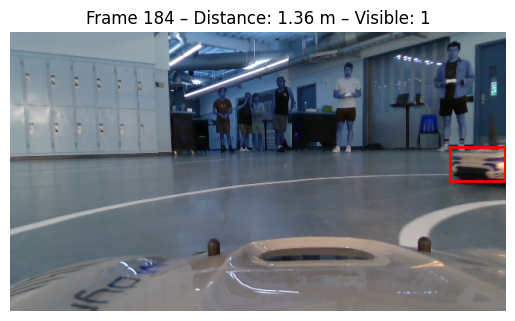

In [47]:
import matplotlib.patches as patches

name = f'bc_acc_left_lidar'
r.get_recording_by_name(name)
images = r.get_all_images('/camera/camera/color/image_raw')

start_frame = 160  # your start frame index
end_frame = start_frame + 50    # your end frame index
shown = 0
max_to_show = 10

for i in range(start_frame, min(end_frame, len(images))):
    image = images[i]
    dist = pts_left[i]
    visible = visible_left[i]

    predictions = model(image, verbose=False)
    if len(predictions) > 0:
        p = predictions[0].cpu()
        all_boxes = p.boxes
        ids = all_boxes.cls.numpy()

        if car_id in ids:
            # Find the first car box index
            car_idx = list(ids).index(car_id)
            box = all_boxes.xyxy[car_idx].numpy()  # [xmin, ymin, xmax, ymax]

            # Plot image with bounding box
            fig, ax = plt.subplots(1)
            ax.imshow(image)

            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)

            plt.title(f"Frame {i} – Distance: {dist:.2f} m – Visible: {visible}")
            plt.axis('off')
            plt.show()

            shown += 1
            if shown >= max_to_show:
                break
